# Literacy and Book Banning

## Research question:  Do literacy rates have any correlation with book bans?

### Methods:  
#### - Import data about banned books and reading test scores  
#### - Organize and clean the data  
#### - Analyze data to discover trends and possible correlations between various features  
#### - Explore data to determine whether there is evidence that areas with different than average literacy rates appear to ban books more or less often than areas with near average literacy rates

# 1. Import modules and read in datasets

In [2]:
import os
from urllib.request import urlopen
from json import loads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axis import Axis
from matplotlib.pyplot import figure
import matplotlib.colors as clrs
import datetime as dt
from matplotlib.dates import (DateFormatter, MinuteLocator, AutoDateLocator, AutoDateFormatter, datestr2num)
import requests
import seaborn as sns

### 1.1 This first dataset, which I will store in a pandas dataframe called "bans," was created by PEN America and available for public use.  Finding this data is what led me to the concept for the project.

In [139]:
url2 = r'https://docs.google.com/spreadsheets/d/1hTs_PB7KuTMBtNMESFEGuK-0abzhNxVv4tgpI5-iKe8/export?exportFormat=csv'
bans = pd.read_csv(url2, skiprows = 2)

In [4]:
bans.head()

,Author,Title,Type of Ban,Secondary Author(s),Illustrator(s),Translator(s),State,District,Date of Challenge/Removal,Origin of Challenge
0,"Àbíké-Íyímídé, Faridah",Ace of Spades,Banned in Libraries and Classrooms,NaN,NaN,NaN,Florida,Indian River County School District,November 2021,Administrator
1,"Acevedo, Elizabeth",Clap When You Land,Banned in Classrooms,NaN,NaN,NaN,Pennsylvania,Central York School District,August 2021,Administrator
2,"Acevedo, Elizabeth",The Poet X,Banned in Libraries,NaN,NaN,NaN,Florida,Indian River County School District,November 2021,Administrator
3,"Acevedo, Elizabeth",The Poet X,Banned in Libraries and Classrooms,NaN,NaN,NaN,New York,Marlboro Central School District,February 2022,Administrator
4,"Acevedo, Elizabeth",The Poet X,Banned Pending Investigation,NaN,NaN,NaN,Texas,Fredericksburg Independent School District,March 2022,Administrator


### 1.2 I then found a dataset from edu.gov containing summary data from reading (and mathematic) proficiency testing from school districts throughout the country.  I will call this dataframe "scores" for this project.  
While data from many school years are available, I chose to use data from a few years before the book ban set, because rather than examining any specific education trends during a specific year, I was wanting to look at overall trends in literacy that may or may not have related to broader reading attitudes or abilities in the area.  I chose to import only certain columns as this is a large dataset that I did not need all variables of for this research.

In [140]:
url = 'https://www2.ed.gov/about/inits/ed/edfacts/data-files/rla-achievement-lea-sy2014-15.csv'
scores = pd.read_csv(url, usecols = ['STNAM','LEAID','LEANM', 'ALL_RLA00NUMVALID_1415', 'ALL_RLA00PCTPROF_1415'])

In [6]:
scores

,STNAM,LEAID,LEANM,ALL_RLA00NUMVALID_1415,ALL_RLA00PCTPROF_1415
0,ALABAMA,100005,Albertville City,2514,32
1,ALABAMA,100006,Marshall County,2988,36
2,ALABAMA,100007,Hoover City,7434,61
3,ALABAMA,100008,Madison City,5232,70
4,ALABAMA,100011,Leeds City,939,39
...,...,...,...,...,...
16156,WYOMING,5605762,Sweetwater County School District #2,1393,52
16157,WYOMING,5605820,Washakie County School District #2,49,50-59
16158,WYOMING,5605830,Teton County School District #1,1396,63
16159,WYOMING,5606090,Weston County School District #7,131,55-59


In [7]:
scores['ALL_RLA00PCTPROF_1415'] = pd.to_numeric(scores['ALL_RLA00PCTPROF_1415'], errors= 'ignore')

In [8]:
issues = scores[pd.to_numeric(scores['ALL_RLA00PCTPROF_1415'], errors='coerce').isnull()]

In [9]:
issues

,STNAM,LEAID,LEANM,ALL_RLA00NUMVALID_1415,ALL_RLA00PCTPROF_1415
137,ALASKA,200003,Lower Yukon School District,1180,LE1
138,ALASKA,200004,Yupiit School District,268,LE1
139,ALASKA,200005,Kashunamiut School District,169,LE5
140,ALASKA,200006,Mount Edgecumbe High School Agency,192,25-29
141,ALASKA,200007,Aleutians East Borough School District,132,30-34
...,...,...,...,...,...
16142,WYOMING,5604380,Park County School District #16,59,60-69
16152,WYOMING,5605680,Sheridan County School District #3,45,50-59
16155,WYOMING,5605700,Fremont County School District #24,198,50-54
16157,WYOMING,5605820,Washakie County School District #2,49,50-59


### 1.3 I later realized that I needed a third dataset with which to more accurately connect the original two.  I called its dataframe simply "data." This was from ed.gov and contained information about district, states, and district ID numbers.

I also included only a few columns from this dataset so as to not slow down the project with data I would not be using for this research.

In [141]:
import requests, zipfile, io

url = "https://nces.ed.gov/ccd/data/zip/ccd_lea_029_1415_w_0216161ar_txt.zip"
filename = 'ccd_lea_029_1415_w_0216161ar.txt'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

data=pd.read_table(filename, delimiter = '\t', on_bad_lines='skip', usecols = ['LEAID','LEA_NAME','STATENAME'])

In [11]:
data.head()

,STATENAME,LEAID,LEA_NAME
0,ALABAMA,100002,Alabama Youth Services
1,ALABAMA,100005,Albertville City
2,ALABAMA,100006,Marshall County
3,ALABAMA,100007,Hoover City
4,ALABAMA,100008,Madison City


### 1.4 Verifying sizes to make sure the sets are not too large

In [142]:
import sys
sys.getsizeof(scores)

3566335

In [146]:
sys.getsizeof(bans)

1625361

In [147]:
sys.getsizeof(data)

2890393

# 2. Cleaning and preparing data

## 2.1 Preparing reading proficiency score data

For clarity, consistency across dataframes, and ease of merging, I will rename and reorganize some of the columns

In [12]:
scores.rename(columns= {'STNAM': 'State', 'LEAID':'ID', 'LEANM':'District', 'ALL_RLA00NUMVALID_1415':'Students_tested', 'ALL_RLA00PCTPROF_1415':'Reading_proficiency_rate'}, inplace=True)

### 2.1.2 Finding and removing any duplicated districts

Adding a column to count the frequency of each book title that was banned

In [13]:
len(scores.index)

16161

In [14]:
print(scores["District"].nunique())

15834


In [15]:
duplicateRows = scores[scores.duplicated(["District"])]
print(duplicateRows)

           State       ID                                           District  \
438      ARIZONA   400417         Arizona Agribusiness & Equine Center  Inc.   
445      ARIZONA   400426         Arizona Agribusiness & Equine Center  Inc.   
448      ARIZONA   400432  Portable Practical Educational Preparation  In...   
466      ARIZONA   400608                                 BASIS School  Inc.   
528      ARIZONA   400787  Kaizen Education Foundation dba Vista Grove Pr...   
...          ...      ...                                                ...   
16043  WISCONSIN  5514250                       River Valley School District   
16047  WISCONSIN  5514520                        Stockbridge School District   
16049  WISCONSIN  5514580                          Stratford School District   
16054  WISCONSIN  5514820                              Thorp School District   
16072  WISCONSIN  5515570                         Washington School District   

       Students_tested Reading_proficie

The above shows 327 Rows have district names that are duplicates. However, knowing that some states may have districts with the same name as districts in other states, I'll check the ID numbers to verify whether these are true duplicates.

In [16]:
duplicateRows = scores[scores.duplicated(["ID"])]
print(duplicateRows)

Empty DataFrame
Columns: [State, ID, District, Students_tested, Reading_proficiency_rate]
Index: []


The empty dataframe for any duplicated ID numbers is empty. This indicates that while 327 districts share the same names as another district, they are likely unique entries.  This made me realize that while both the bans and scores dataframes contain district number, I needed to add the third dataset in order to differenciate between different districts whose names were the same as districts in other states.  The third dataframe contains ID numbers and district names like the scores set as well as state names, which scores does not have.

In [17]:
bans['Title'].value_counts().head(50)

Gender Queer: A Memoir                                                                                      41
All Boys Aren't Blue                                                                                        29
Out of Darkness                                                                                             24
The Bluest Eye                                                                                              22
Lawn Boy                                                                                                    17
The Hate U Give                                                                                             17
The Absolutely True Diary of a Part-Time Indian                                                             16
Me and Earl and the Dying Girl                                                                              14
The Kite Runner                                                                                             12
C

In [18]:
df2 = pd.DataFrame().assign(Title=bans['Title'])
print(df2)

                                                  Title
0                                         Ace of Spades
1                                    Clap When You Land
2                                            The Poet X
3                                            The Poet X
4                                            The Poet X
...                                                 ...
2527                             The Garden of My Imaan
2528  Read the World: Rethinking Literacy for Empath...
2529                                    American Street
2530  Black Enough: Stories of Being Young & Black i...
2531  Grandpa Cacao: A Tale of Chocolate, from Farm ...

[2532 rows x 1 columns]


In [19]:
df2['frequency'] = df2['Title'].map(df2['Title'].value_counts())
print(df2.head(5))

                Title  frequency
0       Ace of Spades          1
1  Clap When You Land          1
2          The Poet X          4
3          The Poet X          4
4          The Poet X          4


In [20]:
bans['Frequency'] = df2['frequency']
print(bans.head())

                   Author               Title  \
0  Àbíké-Íyímídé, Faridah       Ace of Spades   
1      Acevedo, Elizabeth  Clap When You Land   
2      Acevedo, Elizabeth          The Poet X   
3      Acevedo, Elizabeth          The Poet X   
4      Acevedo, Elizabeth          The Poet X   

                          Type of Ban Secondary Author(s) Illustrator(s)  \
0  Banned in Libraries and Classrooms                 NaN            NaN   
1                Banned in Classrooms                 NaN            NaN   
2                 Banned in Libraries                 NaN            NaN   
3  Banned in Libraries and Classrooms                 NaN            NaN   
4        Banned Pending Investigation                 NaN            NaN   

  Translator(s)         State                                    District  \
0           NaN       Florida         Indian River County School District   
1           NaN  Pennsylvania                Central York School District   
2           NaN  

In [21]:
bans.sort_values(by=["Frequency"], inplace=True, ascending=False)
print(bans.head())

            Author                   Title  \
1228  Kobabe, Maia  Gender Queer: A Memoir   
1254  Kobabe, Maia  Gender Queer: A Memoir   
1246  Kobabe, Maia  Gender Queer: A Memoir   
1247  Kobabe, Maia  Gender Queer: A Memoir   
1248  Kobabe, Maia  Gender Queer: A Memoir   

                             Type of Ban Secondary Author(s) Illustrator(s)  \
1228  Banned in Libraries and Classrooms                 NaN            NaN   
1254  Banned in Libraries and Classrooms                 NaN            NaN   
1246  Banned in Libraries and Classrooms                 NaN            NaN   
1247  Banned in Libraries and Classrooms                 NaN            NaN   
1248  Banned in Libraries and Classrooms                 NaN            NaN   

     Translator(s)           State                               District  \
1228           NaN           Idaho               West Ada School District   
1254           NaN           Texas    Prosper Independent School District   
1246           Na

In [22]:
data.rename(columns= {'LEAID':'ID', 'LEA_NAME':'District', 'STATENAME':'State'}, inplace=True)

Editing the format of date/time so that it is consistent through the dataframe

In [23]:
bans['Date'] = pd.to_datetime(bans["Date of Challenge/Removal"], errors='coerce').dt.date

In [24]:
bans['Date of Challenge/Removal'].replace({'Fall 2021': '2021-11-07 00:00:00'}, inplace = True)

In [25]:
bans['Date'].replace({np.nan: '2021-11-07'}, inplace = True)

After creating the additional columns, I can drop others that I will not use for further analysis.

In [26]:
bans.drop(['Secondary Author(s)', 'Illustrator(s)', 'Translator(s)', 'Date of Challenge/Removal'], axis = 1, inplace = True)

### 2.1.5 Remove rows with missing values

In [27]:
missing = bans[bans.isna().any(axis=1)]
print(missing)

Empty DataFrame
Columns: [Author, Title, Type of Ban, State, District, Origin of Challenge, Frequency, Date]
Index: []


In [28]:
missing2 = scores[scores.isna().any(axis=1)].index
print(missing2)

Int64Index([], dtype='int64')


Creating a new column with the average reading proficiency across districts to be used in later analysis

In [29]:
scores['Reading_proficiency_rate'] = pd.to_numeric(scores['Reading_proficiency_rate'], errors = 'coerce')

In [30]:
scores['Average_proficiency'] = scores['Reading_proficiency_rate'].mean()

Verifying that the new columns and everything so far looks ok

In [31]:
scores.head()

,State,ID,District,Students_tested,Reading_proficiency_rate,Average_proficiency
0,ALABAMA,100005,Albertville City,2514,32.0,54.323556
1,ALABAMA,100006,Marshall County,2988,36.0,54.323556
2,ALABAMA,100007,Hoover City,7434,61.0,54.323556
3,ALABAMA,100008,Madison City,5232,70.0,54.323556
4,ALABAMA,100011,Leeds City,939,39.0,54.323556


In [32]:
bans.head()

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date
1228,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Idaho,West Ada School District,Formal Challenge,41,2022-02-01
1254,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Prosper Independent School District,Administrator,41,2022-01-01
1246,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,South Carolina,Fort Mill Schools,Administrator,41,2021-11-01
1247,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Birdville Independent School District,Formal Challenge,41,2021-10-01
1248,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Canutillo Independent School District,Administrator,41,2021-10-01


In [33]:
data.head()

,State,ID,District
0,ALABAMA,100002,Alabama Youth Services
1,ALABAMA,100005,Albertville City
2,ALABAMA,100006,Marshall County
3,ALABAMA,100007,Hoover City
4,ALABAMA,100008,Madison City


In [34]:
data['District'] = data['District'].str.lower()
data['District'] = data['District'].str.capitalize()
data['State'] = data['State'].str.lower()
data['State'] = data['State'].str.capitalize()
bans['District'] = bans['District'].str.lower()
bans['District'] = bans['District'].str.capitalize()
bans['State'] = bans['State'].str.lower()
bans['State'] = bans['State'].str.capitalize()

In [35]:
scores['District'] = scores['District'].str.lower()
scores['District'] = scores['District'].str.capitalize()

In [36]:
scores['State'] = scores['State'].str.lower()
scores['State'] = scores['State'].str.capitalize()

In [37]:
scores.loc[scores['District'] == 'Canaan school district']

,State,ID,District,Students_tested,Reading_proficiency_rate,Average_proficiency
2290,Connecticut,900630,Canaan school district,52,NaN,54.323556
14989,Vermont,5002940,Canaan school district,97,NaN,54.323556


In [38]:
scores[scores.isnull().any(axis=1)]


,State,ID,District,Students_tested,Reading_proficiency_rate,Average_proficiency
137,Alaska,200003,Lower yukon school district,1180,NaN,54.323556
138,Alaska,200004,Yupiit school district,268,NaN,54.323556
139,Alaska,200005,Kashunamiut school district,169,NaN,54.323556
140,Alaska,200006,Mount edgecumbe high school agency,192,NaN,54.323556
141,Alaska,200007,Aleutians east borough school district,132,NaN,54.323556
...,...,...,...,...,...,...
16142,Wyoming,5604380,Park county school district #16,59,NaN,54.323556
16152,Wyoming,5605680,Sheridan county school district #3,45,NaN,54.323556
16155,Wyoming,5605700,Fremont county school district #24,198,NaN,54.323556
16157,Wyoming,5605820,Washakie county school district #2,49,NaN,54.323556


When first combining the third dataset with the others, there were many districts in the set that still seemed to not have an ID number match.  I discovered that a great many of the district names were formatted differently in the two dataframes.  Therefore, I had to go through each entry and edit the formatting or spelling of the names so that they matched those from the book ban dataset.  I was cautious to ensure I verified each state and district name before editing any entry and on occasion needed to use the address from the larger nces.ed.gov dataset to provide clarification that districts with different names were referring to the same.  I took a great deal of time to try to ensure I did not unintentionally mismatch any of these districts with their numbers, however, this is a place that there were many opportunities for mistakes.  If I were doing this project again, I would try to find a more efficient method that allowed less room for possible error.

In [39]:
data['District'] = data['District'].replace(['Downingtown area sd'], 'Downingtown area school district', regex=True)
data['District'] = data['District'].replace(['Rsu 10'], 'Regional school unit no. 56', regex=True)
data['District'] = data['District'].replace(['Harrisonburg city pblc schs'], 'Harrisonburg city public schools', regex=True)
data['District'] = data['District'].replace(['East stroudsburg area sd'], 'East stroudsburg area school district', regex=True)
data['District'] = data['District'].replace(['Goddard'], 'Goddard public schools', regex=True)
data['District'] = data['District'].replace(['Fairview sd'], 'Fairview school district', regex=True)
data['District'] = data['District'].replace(['isd'], 'independent school district', regex=True)
data['District'] = data['District'].replace(['North penn sd'], 'North penn school district', regex=True)
data['District'] = data['District'].replace(['Wissahickon cs'], 'Wissahickon school district', regex=True)
data['District'] = data['District'].replace(['Central kitsap school district' ], 'Central kitsap school district', regex=True)
data['District'] = data['District'].replace(['Loudoun co pblc schs', 'Harlem ud 122',  'Chsd 117', 'Keller isd', 'Killeen isd', 'Prosper isd', 'Spring branch isd', 'Canyons district', 'Fairfax co pblc schs', 'Hanover co pblc schs', 'Lake forest sd 67', 'Ankeny comm school district', 'Waukee comm school district', 'Kutztown area sd', 'Cypress-fairbanks isd', 'Clear creek isd'], ['Loudoun county public schools', 'Harlem school district 122', 'Community high school district 117', 'Keller independent school district', 'Killeen independent school district', 'Prosper independent school district', 'Spring branch independent school district', 'Canyons school district', 'Fairfax county public schools', 'Hanover county public schools', 'Lake forest schools', 'Ankeny community school district', 'Waukee community school district', 'Kutztown area school district', 'Cypress-fairbanks independent school district', 'Clear creek independent school district'], regex=True)
data['District'] = data['District'].replace(['Loudoun co pblc schs'], 'Loudoun county public schools', regex=True)
data['District'] = data['District'].replace(['Harlem ud 122'], 'Harlem school district 122', regex=True)
data['District'] = data['District'].replace(['Chsd 117'], 'Community high school district 117', regex=True)
data['District'] = data['District'].replace(['Pinellas'], 'Pinellas county schools', regex=True)
data['District'] = data['District'].replace(['Osceola'], 'Osceola county school district', regex=True)
data['District'] = data['District'].replace(['Orange'], 'Orange county public schools', regex=True)
data['District'] = data['District'].replace(['Brevard'], 'Brevard public schools', regex=True)
data['District'] = data['District'].replace(['Flagler'], 'Flagler schools', regex=True)
data['District'] = data['District'].replace(['Va beach city pblc schs'], 'Virginia beach city public schools', regex=True)
data['District'] = data['District'].replace(['Central york sd'], 'Central york school district', regex=True)
data['District'] = data['District'].replace(['Granite district'], 'Granite school district', regex=True)
data['District'] = data['District'].replace(['North kansas city 74'], 'North kansas city schools', regex=True)
data['District'] = data['District'].replace(['Collierville'], 'Collierville schools', regex=True)
data['District'] = data['District'].replace(['Rochester community school district'], 'Rochester community schools district', regex=True)
data['District'] = data['District'].replace(['Indian river'], 'Indian river county school district', regex=True)
data['District'] = data['District'].replace(['Lamar cisd'], 'Lamar consolidated independent school district', regex=True)
data['District'] = data['District'].replace(['Clay'], 'Clay county district schools', regex=True)
data['District'] = data['District'].replace(['Forsyth county'], 'Forsyth county schools', regex=True)
data['District'] = data['District'].replace(['Madison co school dist'], 'Madison county schools', regex=True)
data['District'] = data['District'].replace(['Wilson county'], 'Wilson county school district', regex=True)
data['District'] = data['District'].replace(['Bristow'], 'Bristow public schools', regex=True)
data['District'] = data['District'].replace(['Washington district'], 'Washington county school district', regex=True)
data['District'] = data['District'].replace(['Wentzville r-iv'], 'Wentzville school district', regex=True)
data['District'] = data['District'].replace(['Waukesha school district'], 'School district of waukesha', regex=True)
data['District'] = data['District'].replace(['co pblc schs' ], 'county public schools', regex=True)

In [40]:
data['District'] = data['District'].replace(['York 04'], 'Fort mill schools', regex=True)
data['District'] = data['District'].replace(['Hudson city'], 'Hudson city schools', regex=True)
data['District'] = data['District'].replace(['Walton'], 'Walton county school district', regex=True)
data['District'] = data['District'].replace(['Sarasota'], 'Sarasota county school', regex=True)
data['District'] = data['District'].replace(['Santa rosa'], 'Santa rosa county district schools', regex=True)
data['District'] = data['District'].replace(['Polk'], 'Polk county public schools', regex=True)
data['District'] = data['District'].replace(['Lee'], 'Lee county schools', regex=True)
data['District'] = data['District'].replace(['Jackson'], 'Jackson county school district', regex=True)
data['District'] = data['District'].replace(['Hamilton'], 'Hamilton county schools', regex=True)
data['District'] = data['District'].replace(['Lake'], 'Lake county schools', regex=True)
data['District'] = data['District'].replace(['Fort bend independent school district'], 'Fort bend isd', regex=True)
data['District'] = data['District'].replace(['Lamar cindependent school district'], 'Lamar consolidated independent school district', regex=True)
data['District'] = data['District'].replace(['Lake county schools travis independent school district'], 'Lake travis independent school district', regex=True)
data['District'] = data['District'].replace(['Wayzata public school district'], 'Wayzata public schools', regex=True)
data['District'] = data['District'].replace(['R o w v a cusd 208'], 'Rowva cusd 208', regex=True)
data['District'] = data['District'].replace(['St. lucie'], 'St. lucie public schools', regex=True)
data['District'] = data['District'].replace(['Ottumwa comm school district'], 'Ottumwa community school district', regex=True)
data['District'] = data['District'].replace(['Elizabethtown area sd'], 'Elizabethtown area school district', regex=True)
data['District'] = data['District'].replace(['Blount'], 'Blount county schools', regex=True)
data['District'] = data['District'].replace(['Cherokee county'], 'Cherokee county school district', regex=True)
data['District'] = data['District'].replace(['St. johns'], 'St. johns county school district', regex=True)
data['District'] = data['District'].replace(['Blount'], 'Blount county schools', regex=True)
data['District'] = data['District'].replace(['Francis howell r-iii'], 'Francis howell school district', regex=True)
data['District'] = data['District'].replace(['Lake county schools forest schools'], 'Lake forest schools', regex=True)
data['District'] = data['District'].replace(['Hamilton county schools county'], 'Hamilton county schools', regex=True)
data['District'] = data['District'].replace(['Hamilton county schools southeastern schools'], 'Hamilton southeastern schools', regex=True)
data['District'] = data['District'].replace(['Derby'], 'Derby public schools', regex=True)
data['District'] = data['District'].replace(['Elmbrook school district'], 'Elmbrook schools', regex=True)
data['District'] = data['District'].replace(['Hernando'], 'Hernando school district', regex=True)
data['District'] = data['District'].replace(['Bixby'], 'Bixby public schools', regex=True)
data['District'] = data['District'].replace(['Palm beach'], 'Palm beach county school district', regex=True)
data['District'] = data['District'].replace(['Pawtucket'], 'Pawtucket school department', regex=True)
data['District'] = data['District'].replace(['Rockwood r-vi'], 'Rockwood school district', regex=True)
data['District'] = data['District'].replace(['Monett r-i'], 'Monett r-1 school district', regex=True)

In [41]:
data['District'] = data['District'].replace(['Rapid city area school district 51-4'], 'Rapid city area schools', regex=True)
data['District'] = data['District'].replace(['Iredell-statesville schools'], 'Iredell-statesville school district', regex=True)
data['District'] = data['District'].replace(['Duvall'], 'Duval county public schools', regex=True)
data['District'] = data['District'].replace(['Cadott community school district'], 'School district of cadott community', regex=True)
data['District'] = data['District'].replace(['Bonneville joint district'], 'Bonneville joint school district no 93', regex=True)
data['District'] = data['District'].replace(['Broward'], 'Broward county public schools', regex=True)
data['District'] = data['District'].replace(['Medford sd 549c'], 'Medford school district 549c', regex=True)
data['District'] = data['District'].replace(['Sparta township public school district'], 'Sparta township public schools', regex=True)
data['District'] = data['District'].replace(['Mcminn'], 'Mcminn county schools', regex=True)
data['District'] = data['District'].replace(['Wilkes county schools'], 'Wilkes county school district', regex=True)
data['District'] = data['District'].replace(['Pennridge sd'], 'Pennridge school district', regex=True)
data['District'] = data['District'].replace(['Edmond'], 'Edmond public schools', regex=True)

In [42]:
data['District'] = data['District'].replace(['Muskego-norway school district'], 'Muskego-norway schools', regex=True)
data['District'] = data['District'].replace(['Williamson'], 'Williamson county schools', regex=True)
data['District'] = data['District'].replace(['Duval'], 'Duval county public schools', regex=True)
data['District'] = data['District'].replace(['Blount county schools county schools county'], 'Blount county schools', regex=True)
data['District'] = data['District'].replace(['Hudsonville public school district'], 'Hudsonville public schools', regex=True)
data['District'] = data['District'].replace(['Franklin regional sd'], 'Franklin regional school district', regex=True)
data['District'] = data['District'].replace(['Volusia'], 'Volusia county schools', regex=True)
data['District'] = data['District'].replace(['Mcminn county schools county'], 'Mcminn county schools', regex=True)
data['District'] = data['District'].replace(['Williamson county schools county'], 'Williamson county schools', regex=True)
data['District'] = data['District'].replace(['Eastern lancaster county sd'], 'Eastern lancaster county school district', regex=True)
data['District'] = data['District'].replace(['Keokuk comm school district'], 'Keokuk community school district', regex=True)
data['District'] = data['District'].replace(['Fox c-6'], 'Fox c-6 school district', regex=True)
data['District'] = data['District'].replace(['Joint school district no. 2'], 'West ada school district', regex=True)

In [43]:
bans['District'] = bans['District'].replace(['Canaan school district'], 'Canaan schools', regex=True)

In [44]:
connect = pd.merge(bans, data, how='left', left_on=['State', 'District'], right_on = ['State', 'District'])

In [45]:
connect

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date,ID
0,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Idaho,West ada school district,Formal Challenge,41,2022-02-01,1602100.0
1,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Prosper independent school district,Administrator,41,2022-01-01,4836000.0
2,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,South carolina,Fort mill schools,Administrator,41,2021-11-01,4503900.0
3,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Birdville independent school district,Formal Challenge,41,2021-10-01,4810230.0
4,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Canutillo independent school district,Administrator,41,2021-10-01,4812780.0
...,...,...,...,...,...,...,...,...,...
2527,"Joosten, Michael",My Two Dads and Me,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0
2528,"Jones, Patrick",Combat Zone,Banned Pending Investigation,Texas,North east independent school district,Administrator,1,2021-12-01,4832940.0
2529,"Jones, Kelly",Unusual Chickens for the Exceptional Poultry F...,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0
2530,"Jones, Jaida",Master of One,Banned Pending Investigation,Tennessee,Collierville schools,Administrator,1,2022-02-01,4700149.0


In [46]:
total = pd.merge(connect, scores, how='left', on=['ID', 'State'])

In [47]:
total.drop(['Type of Ban', 'District_y', 'Origin of Challenge'], axis = 1)

,Author,Title,State,District_x,Frequency,Date,ID,Students_tested,Reading_proficiency_rate,Average_proficiency
0,"Kobabe, Maia",Gender Queer: A Memoir,Idaho,West ada school district,41,2022-02-01,1602100.0,19709.0,61.0,54.323556
1,"Kobabe, Maia",Gender Queer: A Memoir,Texas,Prosper independent school district,41,2022-01-01,4836000.0,4581.0,91.0,54.323556
2,"Kobabe, Maia",Gender Queer: A Memoir,South carolina,Fort mill schools,41,2021-11-01,4503900.0,6445.0,63.0,54.323556
3,"Kobabe, Maia",Gender Queer: A Memoir,Texas,Birdville independent school district,41,2021-10-01,4810230.0,15347.0,77.0,54.323556
4,"Kobabe, Maia",Gender Queer: A Memoir,Texas,Canutillo independent school district,41,2021-10-01,4812780.0,3928.0,73.0,54.323556
...,...,...,...,...,...,...,...,...,...,...
2527,"Joosten, Michael",My Two Dads and Me,Florida,Duval county public schools,1,2022-01-01,1200480.0,71557.0,47.0,54.323556
2528,"Jones, Patrick",Combat Zone,Texas,North east independent school district,1,2021-12-01,4832940.0,43736.0,79.0,54.323556
2529,"Jones, Kelly",Unusual Chickens for the Exceptional Poultry F...,Florida,Duval county public schools,1,2022-01-01,1200480.0,71557.0,47.0,54.323556
2530,"Jones, Jaida",Master of One,Tennessee,Collierville schools,1,2022-02-01,4700149.0,4388.0,76.0,54.323556


In [48]:
total.rename(columns= {'District_x':'District'}, inplace=True)

Creating a column to count the number of book bans for any title for each district

In [49]:
total['District_bans'] = total.groupby('District')['District'].transform('count')

Checking the merged dataframe

In [50]:
total

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date,ID,District_y,Students_tested,Reading_proficiency_rate,Average_proficiency,District_bans
0,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Idaho,West ada school district,Formal Challenge,41,2022-02-01,1602100.0,Joint school district no. 2,19709.0,61.0,54.323556,2
1,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Prosper independent school district,Administrator,41,2022-01-01,4836000.0,Prosper isd,4581.0,91.0,54.323556,23
2,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,South carolina,Fort mill schools,Administrator,41,2021-11-01,4503900.0,York 04,6445.0,63.0,54.323556,1
3,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Birdville independent school district,Formal Challenge,41,2021-10-01,4810230.0,Birdville isd,15347.0,77.0,54.323556,14
4,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Canutillo independent school district,Administrator,41,2021-10-01,4812780.0,Canutillo isd,3928.0,73.0,54.323556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,"Joosten, Michael",My Two Dads and Me,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0,Duval,71557.0,47.0,54.323556,176
2528,"Jones, Patrick",Combat Zone,Banned Pending Investigation,Texas,North east independent school district,Administrator,1,2021-12-01,4832940.0,North east isd,43736.0,79.0,54.323556,435
2529,"Jones, Kelly",Unusual Chickens for the Exceptional Poultry F...,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0,Duval,71557.0,47.0,54.323556,176
2530,"Jones, Jaida",Master of One,Banned Pending Investigation,Tennessee,Collierville schools,Administrator,1,2022-02-01,4700149.0,Collierville,4388.0,76.0,54.323556,327


In [51]:
problems = total[total.isnull().any(axis=1)]
problems

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date,ID,District_y,Students_tested,Reading_proficiency_rate,Average_proficiency,District_bans
2094,"Burgess, Rebecca",How to Be Ace: A Memoir of Growing Up Asexual,Banned Pending Investigation,Vermont,Canaan schools,Formal Challenge,1,2022-03-01,NaN,NaN,NaN,NaN,NaN,1


After reviewing the full "data" dataframe, I discovered that this school is not listed in it.  As it is only one entry, I will imput the scores manually so that the information for reading scores and book ban can be combined.  As it does not have a district ID number listed, this will still be a missing value.  However, as the IDs were used for the intention of combining the information about book bans and test scores, this will not be a problem for analysis. 

In [52]:
total = total.drop(['District_y'], axis = 1)

In [53]:
total.loc[2094, ['ID', 'Students_tested', 'Reading_proficiency_rate', 'Average_proficiency', 'District_bans']] = [5002940, 97, 57, 54.323556, 1]

In [54]:
problems = total[total.isnull().any(axis=1)]
problems

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date,ID,Students_tested,Reading_proficiency_rate,Average_proficiency,District_bans


In [55]:
total

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date,ID,Students_tested,Reading_proficiency_rate,Average_proficiency,District_bans
0,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Idaho,West ada school district,Formal Challenge,41,2022-02-01,1602100.0,19709.0,61.0,54.323556,2
1,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Prosper independent school district,Administrator,41,2022-01-01,4836000.0,4581.0,91.0,54.323556,23
2,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,South carolina,Fort mill schools,Administrator,41,2021-11-01,4503900.0,6445.0,63.0,54.323556,1
3,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Birdville independent school district,Formal Challenge,41,2021-10-01,4810230.0,15347.0,77.0,54.323556,14
4,"Kobabe, Maia",Gender Queer: A Memoir,Banned in Libraries and Classrooms,Texas,Canutillo independent school district,Administrator,41,2021-10-01,4812780.0,3928.0,73.0,54.323556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,"Joosten, Michael",My Two Dads and Me,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0,71557.0,47.0,54.323556,176
2528,"Jones, Patrick",Combat Zone,Banned Pending Investigation,Texas,North east independent school district,Administrator,1,2021-12-01,4832940.0,43736.0,79.0,54.323556,435
2529,"Jones, Kelly",Unusual Chickens for the Exceptional Poultry F...,Banned Pending Investigation,Florida,Duval county public schools,Administrator,1,2022-01-01,1200480.0,71557.0,47.0,54.323556,176
2530,"Jones, Jaida",Master of One,Banned Pending Investigation,Tennessee,Collierville schools,Administrator,1,2022-02-01,4700149.0,4388.0,76.0,54.323556,327


** If you would like to view any of the dataframes in their entirety, you can use " pd.set_option('display.max_rows', None) ".  While I used that option during my analysis to check individual rows as I progressed or when I ran into problems, I decided to remove it before submitting the project so that I did not make this more difficult for anyone to run.

# 3. Exploratory data analysis

## 3.1 Simple information about each cleaned dataset

### 3.1.1 Scores data

In [102]:
scores.describe(include = 'all')

,State,ID,District,Students_tested,Reading_proficiency_rate,Average_proficiency,Diff_from_mean_abs
count,16161,1.616100e+04,16161,16161.000000,11250.000000,1.616100e+04,11250.000000
unique,52,NaN,15687,NaN,NaN,NaN,NaN
top,Texas,NaN,Basis school inc.,NaN,NaN,NaN,NaN
freq,1220,NaN,11,NaN,NaN,NaN,NaN
mean,NaN,2.970734e+06,NaN,1603.600272,54.323556,5.432356e+01,16.302013
std,NaN,1.473374e+06,NaN,5849.720468,19.430093,7.105647e-15,10.571152
min,NaN,1.000050e+05,NaN,1.000000,2.000000,5.432356e+01,0.323556
25%,NaN,1.806060e+06,NaN,155.000000,40.000000,5.432356e+01,7.323556
50%,NaN,3.016810e+06,NaN,441.000000,55.000000,5.432356e+01,15.323556
75%,NaN,4.024870e+06,NaN,1242.000000,70.000000,5.432356e+01,23.676444


In [57]:
scores.dtypes

State                        object
ID                            int64
District                     object
Students_tested               int64
Reading_proficiency_rate    float64
Average_proficiency         float64
dtype: object

### 3.1.2 Bans data

In [101]:
bans.describe(include = 'all')

,Author,Title,Type of Ban,State,District,Origin of Challenge,Frequency,Date
count,2532,2532,2532,2532,2532,2532,2532.000000,2532
unique,1149,1648,4,32,138,3,NaN,12
top,"Hopkins, Ellen",Gender Queer: A Memoir,Banned Pending Investigation,Texas,Central york school district,Administrator,NaN,2021-12-01
freq,43,41,1375,801,441,2383,NaN,513
mean,NaN,NaN,NaN,NaN,NaN,NaN,4.244866,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6.986983,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN


## 3.2 Univariate analysis

### 3.2.1 Scores

In [ ]:
scores['Reading_proficiency_rate'].describe()

In [59]:
scores['Reading_proficiency_rate'].median()

55.0

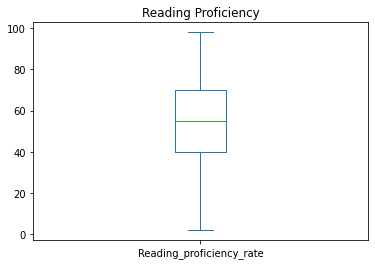

In [62]:
ax = scores[['Reading_proficiency_rate']].plot(kind='box', title='Reading Proficiency')
plt.show()

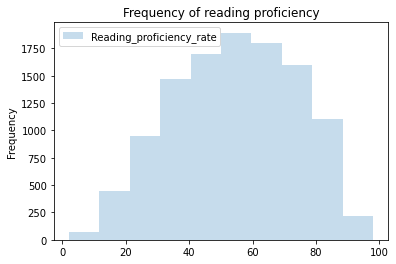

In [64]:
_ = scores[['Reading_proficiency_rate']].plot(kind='hist', title='Frequency of reading proficiency', alpha = 0.25)

### 3.2.2 Bans

#### 3.2.2.1 Bans by book

In [66]:
title_counts = bans['Title'].value_counts().rename_axis('Banned Title').to_frame('Count')
title_counts

,Count
Banned Title,
Gender Queer: A Memoir,41
All Boys Aren't Blue,29
Out of Darkness,24
The Bluest Eye,22
Lawn Boy,17
...,...
Getting It,1
Rainbow High (Rainbow Trilogy Series),1
Rainbow Road (Rainbow Trilogy Series),1


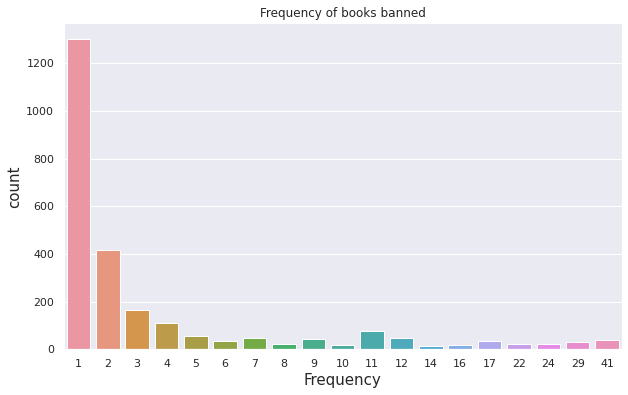

In [107]:
graph = plt.figure(figsize = (10, 6))

graph = sns.countplot(data = bans, x = 'Frequency').set(title='Frequency of books banned')

[Text(0.5, 0, 'Frequency of each banned title'),
 Text(0.5, 1.0, 'Density of frequencies')]

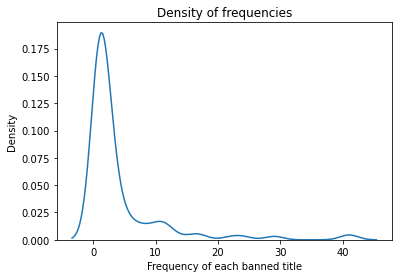

In [69]:
_ = sns.kdeplot(bans['Frequency'])
_.set(xlabel = 'Frequency of each banned title', title = 'Density of frequencies')

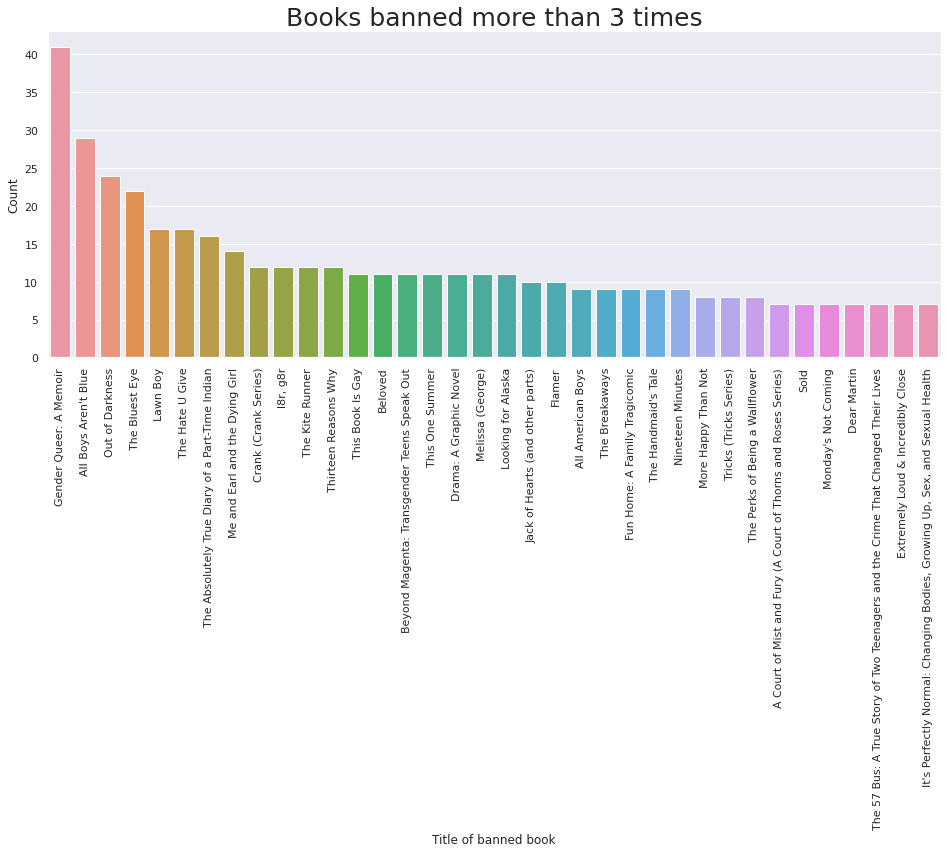

In [93]:
title_vals = bans['Title'].value_counts()[:36]
g = plt.figure(figsize = (16, 6))
g = sns.barplot(x = title_vals.index, y = title_vals)
_ = g.set_xticklabels(labels = title_vals.index, rotation = 90)
_ = plt.rcParams["axes.labelsize"] = 20
_ = plt.title('Books banned more than 3 times', size = 25)
_ = g.set(xlabel = 'Title of banned book', ylabel = 'Count')

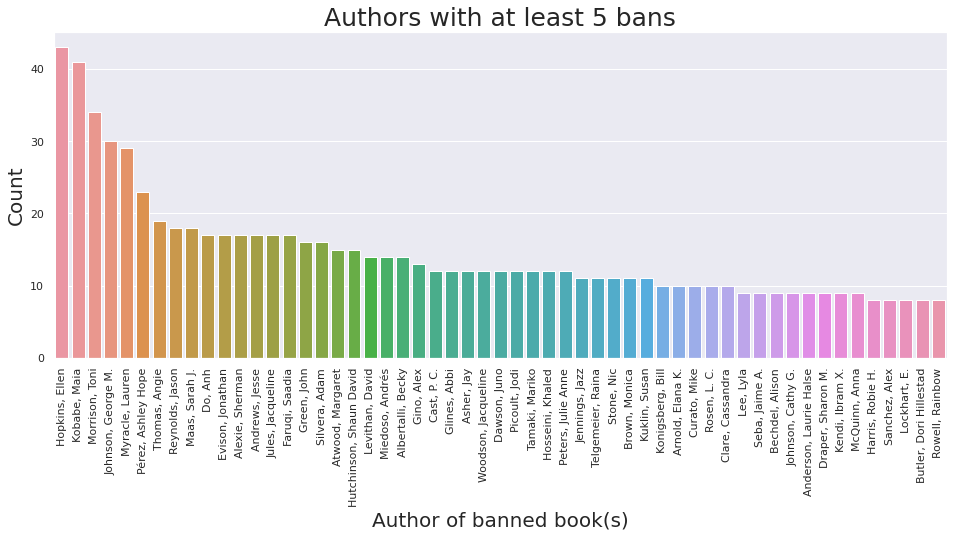

In [94]:
author_vals = bans['Author'].value_counts()[:55]
g = plt.figure(figsize = (16, 6))
g = sns.barplot(x = author_vals.index, y = author_vals)
_ = g.set_xticklabels(labels = author_vals.index, rotation = 90)
_ = plt.rcParams["axes.labelsize"] = 15
_ = plt.title('Authors with at least 5 bans', size = 25)
_ = g.set(xlabel = 'Author of banned book(s)', ylabel = 'Count')

#### 3.2.2.1 Bans by state

In [67]:
states = bans['State'].value_counts().rename_axis('States with banned books').to_frame('Number of bans')
states

,Number of bans
States with banned books,
Texas,801
Florida,566
Pennsylvania,458
Tennessee,349
Oklahoma,43
Michigan,41
Kansas,30
Wisconsin,29
Missouri,27


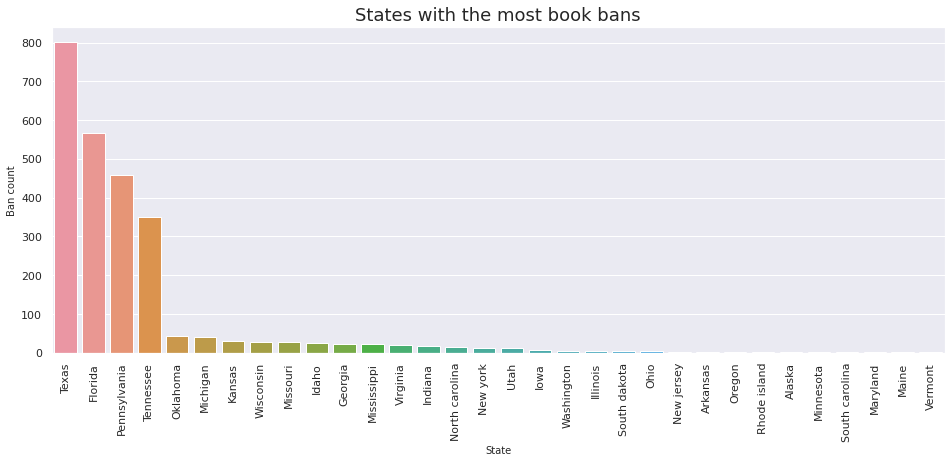

In [111]:
state_vals = bans['State'].value_counts()
g = plt.figure(figsize = (16, 6))
g = sns.barplot(x = state_vals.index, y = state_vals)
_ = g.set_xticklabels(labels = state_vals.index, rotation = 90)
_ = plt.rcParams["axes.labelsize"] = 10
_ = plt.title('States with the most book bans', size = 18)
_ = g.set(xlabel = 'State', ylabel = 'Ban count')

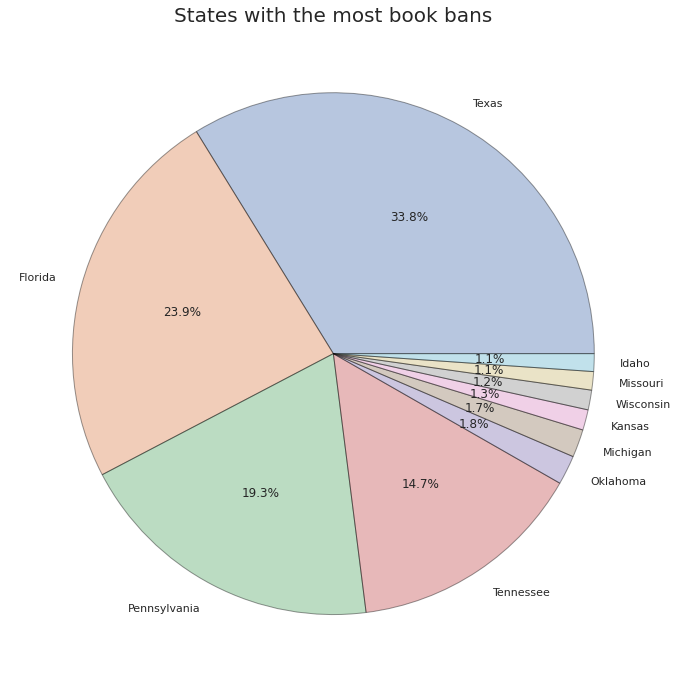

In [95]:
state_vals2 = bans['State'].value_counts()[:10]
g2 = plt.figure(figsize=(12, 12))
g2 = plt.pie(state_vals2, labels=state_vals2.index, autopct='%.1f%%', wedgeprops={'edgecolor':'black', 'alpha':0.4})
g2 = plt.title('States with the most book bans', size = 20)

#### 3.2.2.1 Bans by district

In [73]:
bans.groupby('State')['District'].describe()

,count,unique,top,freq
State,,,,
Alaska,1,1,Anchorage school district,1
Arkansas,1,1,Siloam springs school district,1
Florida,566,21,Duval county public schools,176
Georgia,23,2,Forsyth county schools,13
Idaho,26,3,Nampa school district,23
Illinois,5,4,Lake forest schools,2
Indiana,18,3,Carmel clay schools,9
Iowa,8,4,Waukee community school district,3
Kansas,30,2,Goddard public schools,29


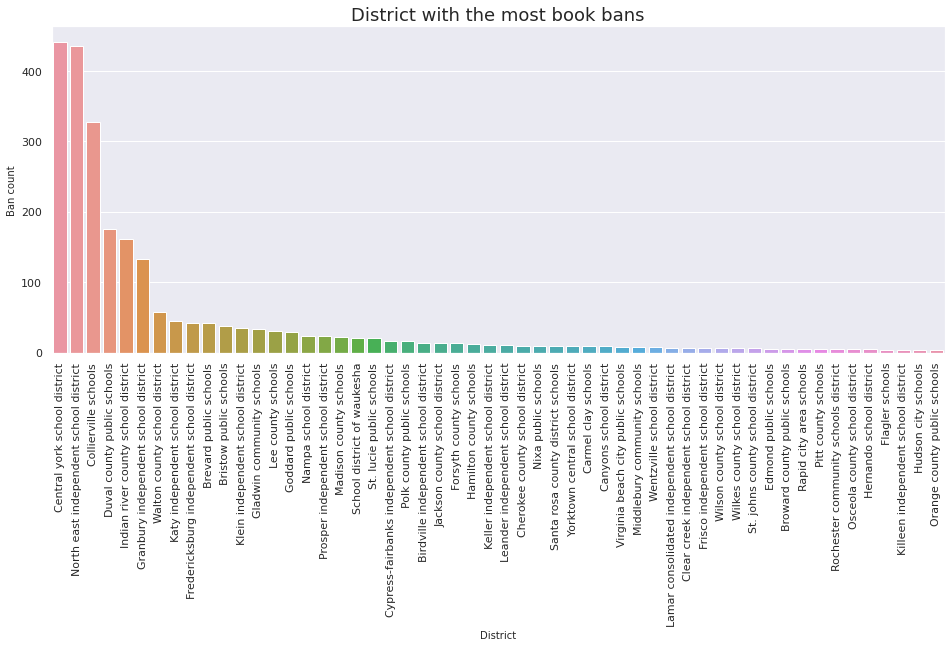

In [115]:
dist_vals = bans['District'].value_counts().loc[lambda x : x>3]
g = plt.figure(figsize = (16, 6))
g = sns.barplot(x = dist_vals.index, y = dist_vals)
_ = g.set_xticklabels(labels = dist_vals.index, rotation = 90)
_ = plt.rcParams["axes.labelsize"] = 10
_ = plt.title('District with the most book bans', size = 18)
_ = g.set(xlabel = 'District', ylabel = 'Ban count')

In [116]:
pd.set_option('display.max_rows', None)

# 4. Comparative data analysis

In [117]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [118]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 4.1 Reading proficiency differences

Using analysis of variance to determine whether individual district reading proficiency differs from overal reading proficiency to a statistically significant extent.

In [119]:
mod4 = ols('Average_proficiency ~ Reading_proficiency_rate', data = scores).fit()

In [120]:
anova_table = sm.stats.anova_lm(mod4, typ = 2)
print(anova_table)

                                sum_sq       df         F    PR(>F)
Reading_proficiency_rate  1.822710e-26      1.0  4.977108  0.025705
Residual                  4.119227e-23  11248.0       NaN       NaN


The results of this analysis of variance test indicate that there is a statistically significant difference between the reading proficiency of different districts and the overall average reading proficiency.  I will now examine that difference a bit further.

In [121]:
total['Diff_from_mean'] = scores['Average_proficiency'] - scores['Reading_proficiency_rate']

In [122]:
total['Diff_from_mean'].describe()

count    1712.000000
mean       12.090495
std        17.908887
min       -43.676444
25%         1.323556
50%        15.323556
75%        25.323556
max        51.323556
Name: Diff_from_mean, dtype: float64

In [123]:
total['Reading_proficiency_rate'] = pd.to_numeric(total['Reading_proficiency_rate'], errors = 'coerce')

In [124]:
scores['Diff_from_mean_abs'] = abs(scores['Average_proficiency'] - scores['Reading_proficiency_rate'])

In [125]:
large_diff = scores.loc[(scores['Diff_from_mean_abs'] >= 45)]

In [126]:
large_diff_state = scores.loc[(scores['Diff_from_mean_abs'] >= 35)]

In [127]:
len(scores)

16161

In [128]:
len(large_diff)

45

Note that the following graph shows only the difference, which includes those that vary far from average reading proficiency in both a positive and a negative direction.

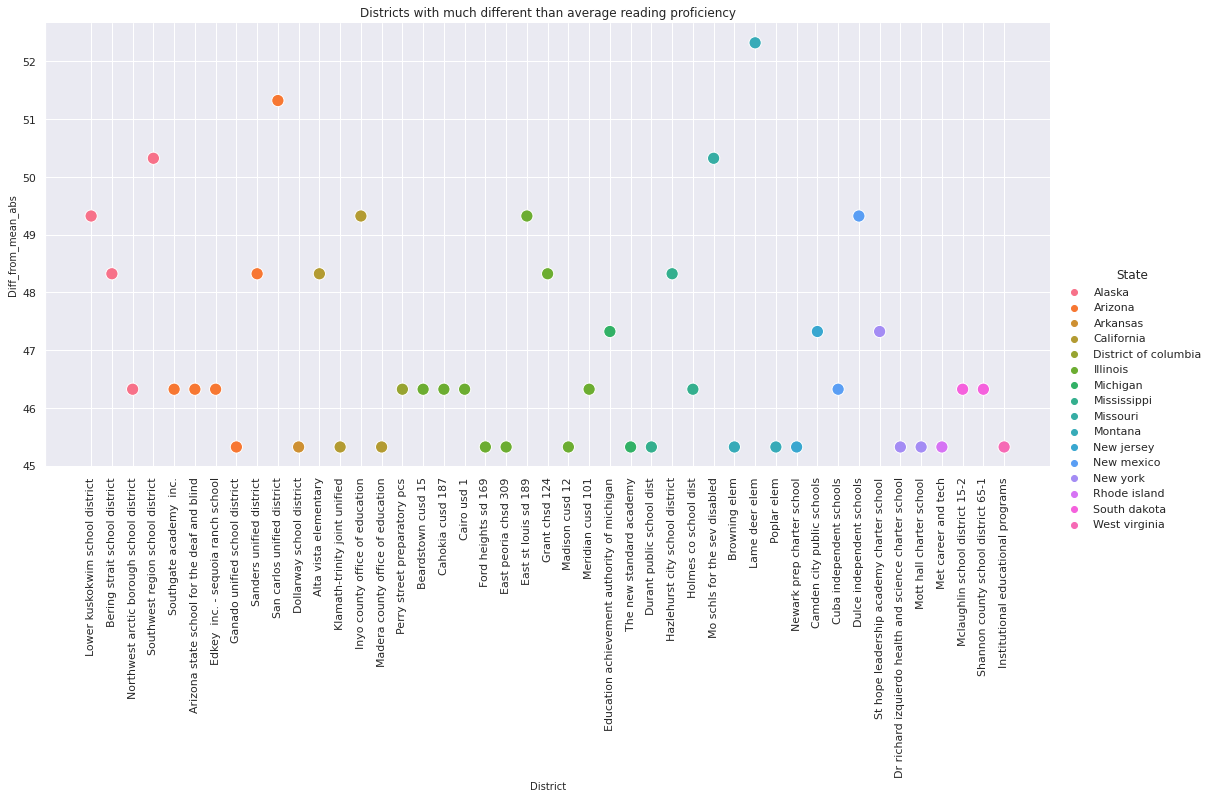

In [129]:
chart = sns.relplot(data=large_diff, x="District", y="Diff_from_mean_abs", hue= "State", height=7, aspect=15/7, s = 150).set(title = 'Districts with much different than average reading proficiency')
chart.set_xticklabels(rotation=90)

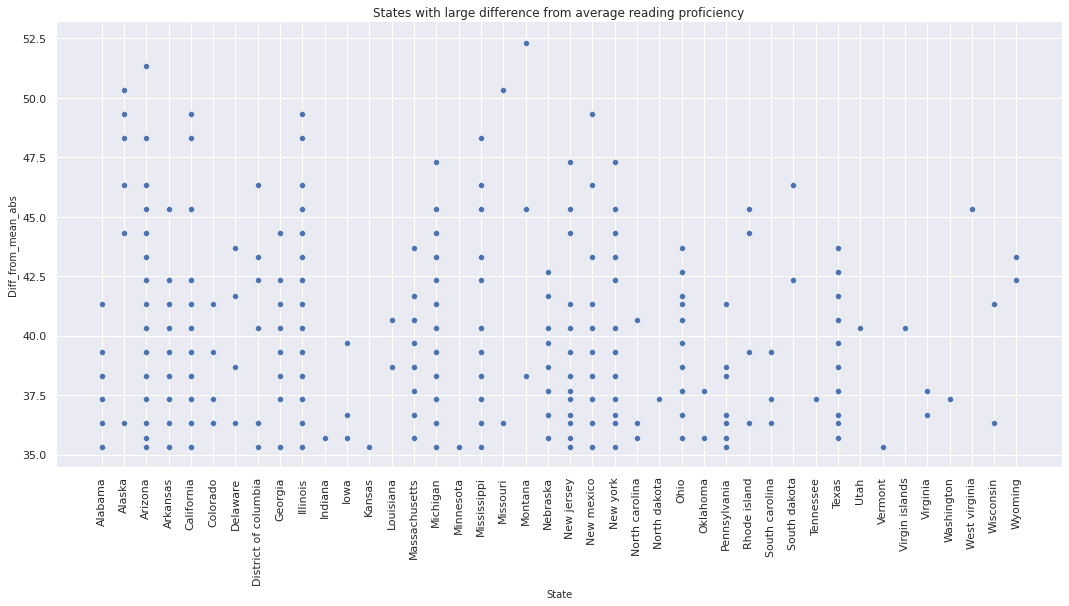

In [130]:
chart = sns.relplot(data=large_diff_state, x="State", y="Diff_from_mean_abs", height=7, aspect=15/7).set(title = 'States with large difference from average reading proficiency')
chart.set_xticklabels(rotation=90)

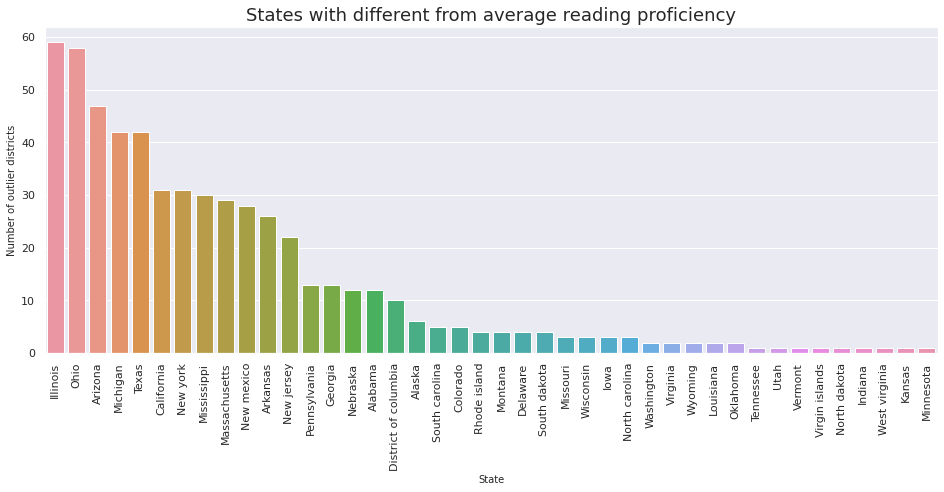

In [131]:
state_vals = large_diff_state['State'].value_counts()
g = plt.figure(figsize = (16, 6))
g = sns.barplot(x = state_vals.index, y = state_vals)
_ = g.set_xticklabels(labels = state_vals.index, rotation = 90)
_ = plt.rcParams["axes.labelsize"] = 10
_ = plt.title('States with different from average reading proficiency', size = 18)
_ = g.set(xlabel = 'State', ylabel = 'Number of outlier districts')

## 4.2 Bivariate analysis between reading proficiency and book bans

### Is there correlation between reading proficiency and book bans?

#### 4.2.1 Basic scatterplot visualization

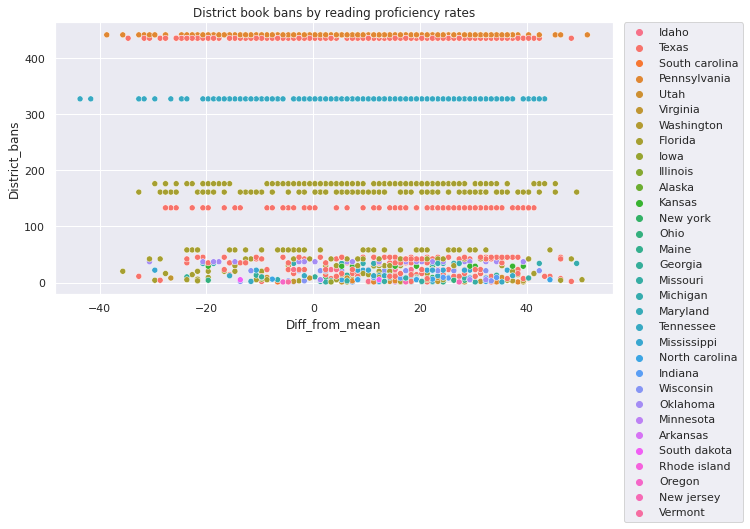

In [132]:
chart3 = sns.set(rc={'figure.figsize':(10, 5)})
chart3 = sns.scatterplot(data=total, x="Diff_from_mean", y="District_bans", hue= "State").set(title = 'District book bans by reading proficiency rates')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Hmm.  I notice a few things about this scatterplot:  first, the numbers of bans by district seemed to be clumped together in about 4 major groups.  It appears as though most districts that have banned books, have banned less than 100, but there are groups of districts that have banned between 100 and 200, between 200 and 300, and more than 400.  No districts from this data banned between 200 and 300 books.  Considering that from the numbers, we saw that the vast majority of book titles banned are the same as those banned in other districts, perhaps it isn't surprising that the number of bans is also similar in many areas.  Two other things that I notice from this chart surprised me.  One, with the exception of districts with less than about 50 bans, the number of bans is highly related to the state.  Every one of the districts with over 100 banned books are from one of five states.  Each of these groupings shows that districts in each of these states that ban books seem to be likely to ban approximately the same number of books as other districts in that state.  The other surprising thing that I notice is that there does seem to be a correlation between different than average reading proficiency scores and the number of book bans.  The scatterplot clearly leans at least slight to the right.  This suggests that districts with higher than average reading proficiency also have more book bans.  None of this suggests any possible causative relationship, but the correlation is interesting to observe.

#### 4.2.2 Pearson's correlation coefficient

In [133]:
print(total['Reading_proficiency_rate'].corr(total['District_bans']))

0.3891730207742676


#### 4.2.3 Correlation heatmap comparing all variables

<AxesSubplot:>

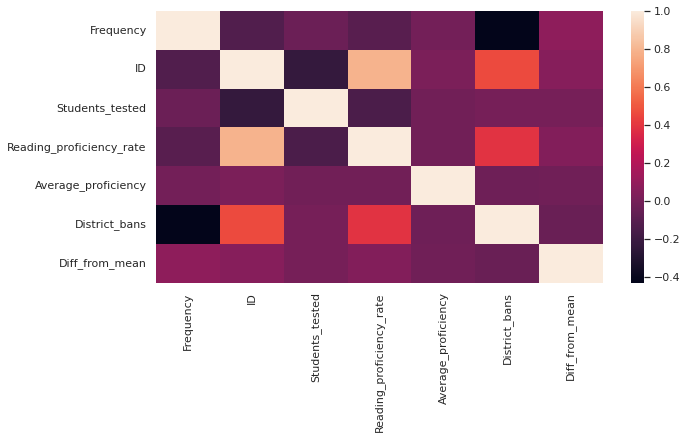

In [134]:
corr = total.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# 5. Conclusions

Before beginning this research, I imagined that were there any correlation, it would be a negative one.  That is to say that I hypothized that where more books were banned there might be lower than average reading proficiency.  However, my research indicates the opposite.  I cannot make any larger predictions or stronger guesses about causation, but these findings do leave me curious to look more closely and to examine how these results may change when adding additional variables to the analysis. 

If I were doing this again or doing further research, I would want to ensure that each connected district is an accurate representation.  For example, if any of the district lines have changed between when these test scores and the book bans then even if all the ID numbers and districts are accurately merged, the data may not reflect the districts.  I would also want to spend more time to verify the accuracy of each dataset and of the cleaning and analysis I did.  I did use reputable sources and was cautious in my research and analysis.  I also edited and checked back through the research as I went and after I completed it.  However, having peer reviews will also help to provide outside views and assist in checking my work.  There may still be errors that I would want to correct.  

For future research, I would include reading proficiency over a longer time period to establish broader patterns for each district.  I would also be interested in examining other possibly relevant variables, particularly economic environment, political views, religious views, parental involvement, and graduation rates for each district.  If I included all these factors, I could develop algorithms to examine which, if any, variable(s) most correlate with book bans.  This may allow for seeing a more complete picture.  It might be that reading rates and book bans correlate only because they are a reflection of other patterns in school districts.  More research would be necessary to discover whether this could be the case.

#### *Key finding:  This analysis shows a positive correlation (~0.3892) between reading proficiency rate and book bans in school districts throughout the United States.